In [58]:
# import statements + data load
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
spotify_dth = pd.read_csv("data/charts.csv")

In [59]:
# basic data cleaning/type conversions
indexes = range(0, len(spotify_dth)) # index
# converting to datetime
spotify_dth['date'] = pd.to_datetime(spotify_dth['date'], format='%Y-%m-%d')

# dropping all rows that did not make the #1 spot
#spotify_dth = [row for index, row in tqdm(spotify_dth.iterrows(), total=len(spotify_dth)) if row['rank'] == 1]
spotify_dth = spotify_dth.drop([index for index, row in spotify_dth.iterrows() if row['rank'] != 1])


# dropping all rows that are not in the US
spotify_dth_US = spotify_dth.drop([index for index, row in spotify_dth.iterrows() if row['region'] != 'United States'])
#spotify_dth_US = [row for index, row in tqdm(spotify_dth.iterrows(), total=len(spotify_dth)) if row['region'] == 'United States']


# resetting indeces of both
spotify_dth.reset_index(inplace=True, drop=True)
spotify_dth_US.reset_index(inplace=True, drop=True)

# saving to csv for reference
spotify_dth.to_csv("data/number_one_all_regions_2017_2021.csv", index=False)
spotify_dth_US.to_csv("data/number_one_US_2017_2021.csv", index=False)
del spotify_dth # removing var to free up memory


In [104]:
# now reading all of the data from the prior project group
years = [2017, 2018, 2019, 2020, 2021]
spotify_dict = {}
for year in years:
    temp_df_name = "spotify_" + str(year) # concatenating df name
    temp_df_directory = "data/" + str(year) + "_complete" + ".csv" # concatenating directory name
    spotify_dict[temp_df_name] = pd.read_csv(temp_df_directory) # adding df to dict
    spotify_dict[temp_df_name].drop(['Unnamed: 0', 'Streams'], axis=1, inplace=True) # dropping index col
    spotify_dict[temp_df_name]["year"] = year # adding identifying year column

# concatenating into a single df
spotify_2017_2021 = pd.concat(spotify_dict.values(), ignore_index=True)
# dropping duplicate songs (if from the same artist)
spotify_2017_2021.drop_duplicates(['Song Names', 'Artists'], keep='first', inplace=True)
spotify_2017_2021.reset_index(inplace=True, drop=True) # resetting index
# renaming song title and artist
spotify_2017_2021.rename(columns={'Song Names': 'title', 'Artists':'artist'}, inplace=True)

# merging in extra features from group's df
spotify_merged = spotify_dth_US.merge(spotify_2017_2021[['title', 'artist', 'Danceability', 'Energy', 'Key', 'Loudness',
                                                    'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
                                                    'Valence', 'Tempo', 'Time Signature', 'year']], on=['title', 'artist'], how='left')

# dropping NA's we acquired (aka drops rows we cannot get extra features for)
spotify_merged.dropna(subset=['Danceability'], inplace=True)
spotify_merged.reset_index(inplace=True, drop=True) # resetting index


In [105]:
# so with 335 NAs in streams, we have two options
# include stream count to also account for streaming amount
# or drop the feature and assume only the genre, danceability, etc. + the covid timeline are what matter...
# let's split it into two dfs and simply try both
spotify_merged_streams_incl = spotify_merged.dropna(subset=['streams'], inplace=False).copy()
spotify_merged_streams_dropped = spotify_merged.drop(['streams'], axis=1, inplace=False).copy()

# resetting index again
spotify_merged_streams_incl.reset_index(inplace=True, drop=True)
spotify_merged_streams_dropped.reset_index(inplace=True, drop=True)

print("length of streams included:",len(spotify_merged_streams_incl),"\nlength of streams dropped:", len(spotify_merged_streams_dropped))


length of streams included: 1257 
length of streams dropped: 1592


In [106]:
# tracking covid period
def map_dates_to_values(date):
    if date < pd.to_datetime('2019-03-01'):
        return 1
    elif (date > pd.to_datetime('2019-03-01')) and (date < pd.to_datetime('2022-01-01')):
        return 2
    else:
        return 3
# Creating new column based on the dates
spotify_merged_streams_incl.loc[:, 'covid_period'] = spotify_merged_streams_incl['date'].apply(map_dates_to_values)
spotify_merged_streams_dropped.loc[:, 'covid_period'] = spotify_merged_streams_dropped['date'].apply(map_dates_to_values)

In [107]:
# let's go ahead and drop the "title", "rank", "date", "artist", "url", "region", "chart", "trend", "year" for each
# we could come back to this and also try fitting into an nn to get character differences too per song/artist
# as well, we could keep the date as well and try to predict the date or simply group (unsupervised)
spotify_merged_streams_incl.drop(["title", "rank", "date", "artist", "url", "region", "chart", "trend", "year"], axis=1, inplace=True)
spotify_merged_streams_dropped.drop(["title", "rank", "date", "artist", "url", "region", "chart", "trend", "year"], axis=1, inplace=True)

In [108]:
# deleting unneeded dfs
#del spotify_dth_US, spotify_2017_2021, spotify_merged

In [109]:
# alright now it's time to push into the models...
# other imports needed for ML and data cleaning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# we can't use f1, or anything conf matrix metrics due to no probabilities
from sklearn.metrics import accuracy_score, roc_curve, auc, make_scorer, roc_auc_score, ConfusionMatrixDisplay, f1_score, confusion_matrix, accuracy_score, classification_report, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, LearningCurveDisplay, learning_curve


In [110]:
# just performing this split on the included streams, you can do the same for dropped

# training and testing splits
# Pull Y variable out which is balance
X = spotify_merged_streams_incl.iloc[:, 0:13].to_numpy()
y = spotify_merged_streams_incl.iloc[:, 13:14].to_numpy().flatten()

# basic T/T/Split modeling due to large size of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)


In [111]:
# debugging...
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((842, 13), (415, 13), (842,), (415,))

In [127]:
# my favorite frankenfunction

def metrics_classification_scorer(y_train, y_test, y_pred, y_proba, show_stats = True, save_f1 = False):
    """

    :param y_test: your testing data
    :param y_pred: your predictions generated from classifier
    :param y_proba: your probabilities generated from classifier
    :param show_stats: default is True, shows ROC Curve, and all other Metrics
    :param save_auc: saves AUC score if desired (must write to variable)
    :return: plots of ROC curve, Conf Matrix Metrics, and AUC Score
    """

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    # y_onehot_test.shape  # (n_samples, n_classes)

    if show_stats:
        RocCurveDisplay.from_predictions(
            y_onehot_test.ravel(),
            y_proba.ravel(),
            name="micro-average OvR",
            color="darkorange",
        )
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))
        plt.show()

    # micro_roc_auc_ovr = roc_auc_score(
    #     y_test,
    #     y_proba,
    #     multi_class="ovr",
    #     average="micro",
    # )

    if show_stats:
        # print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}\n")
        print(f"Test Set Accuracy : {accuracy_score(y_test, y_pred) * 100} %\n")
        print(f"Classification Report : \n\n{classification_report(y_test, y_pred)}")


    # saves auc score if desired
    if save_f1: return f1_score(y_test, y_pred, average='macro')

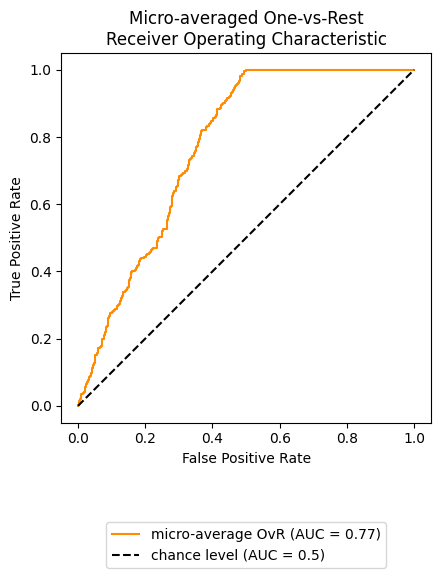

Test Set Accuracy : 50.12048192771085 %

Classification Report : 

              precision    recall  f1-score   support

           1       0.50      1.00      0.67       208
           2       0.00      0.00      0.00       207

    accuracy                           0.50       415
   macro avg       0.25      0.50      0.33       415
weighted avg       0.25      0.50      0.33       415



/Users/Andrew/Documents/School/Spring 2023 Graduate UCSD/COGS 209/spotify_covid_miniproject/environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Andrew/Documents/School/Spring 2023 Graduate UCSD/COGS 209/spotify_covid_miniproject/environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Andrew/Documents/School/Spring 2023 Graduate UCSD/COGS 209/spotify_covid_miniproject/environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarn

In [128]:
# let's try using a logit, max iterations needed to be raised due to terrible convergence rate
# indicating this will not end with good test results...
# logit_fitted = LogisticRegression(max_iter = 1000).fit(X_train, y_train)
# logit_y_pred = logit_fitted.predict(X_test)
# logit_y_prob = logit_fitted.predict_proba(X_train)


logit = LogisticRegression(max_iter = 1000, multi_class='ovr').fit(X_train, y_train)
y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)
logit_f1 = metrics_classification_scorer(y_train, y_test, y_pred, y_prob, save_f1 = True)

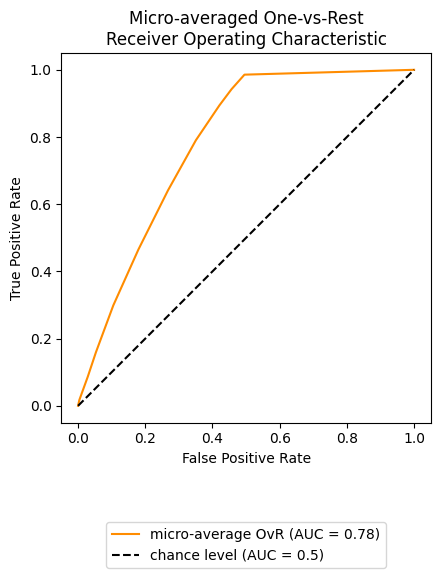

Test Set Accuracy : 53.73493975903615 %

Classification Report : 

              precision    recall  f1-score   support

           1       0.53      0.76      0.62       208
           2       0.57      0.31      0.40       207

    accuracy                           0.54       415
   macro avg       0.55      0.54      0.51       415
weighted avg       0.55      0.54      0.51       415



In [130]:
knn = KNeighborsClassifier(n_neighbors = 10).fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)
knn_f1 = metrics_classification_scorer(y_train, y_test, y_pred, y_prob, save_f1 = True)


In [137]:
print("base f1 for logit:\n", logit_f1, "base f1 for knn:", knn_f1)

base f1 for logit:
 0.33386837881219905 base f1 for knn: 0.5128869760845112
